In [1]:
# Libraries

import numpy
import os
import platform
import shutil
import sys
import warnings

In [2]:
# Root directory

ROOT = os.getcwd()

while not ROOT.endswith('upolanc-thesis') :
	ROOT = os.path.abspath(os.path.join(ROOT, os.pardir))

	if len(ROOT) < len('upolanc-thesis') :
		if   platform.system() == 'Linux' :
			ROOT = '/d/hpc/home/up4472/workspace/upolanc-thesis'
		elif platform.system() == 'Windows' :
			ROOT = 'C:\\Developer\\Workspace\\PyCharm\\Projects\\upolanc-thesis'
		else :
			raise ValueError()

		print(f'Warning : could not find correct directory, using default : {ROOT}')
		break

if ROOT not in sys.path :
	sys.path.append(ROOT)

os.chdir(ROOT)

In [3]:
# Code

from source.python.data.feature import annodata as data_anndata
from source.python.io           import loader   as data_loader
from source.python.io           import writer   as data_writer

# 1. Setup

In [4]:
# Setup some directory paths

CWD = ROOT
OUT = os.path.join(CWD, 'output')
RES = os.path.join(CWD, 'resources')

OUT_DATA  = os.path.join(OUT,      'nbp02-anndata')
OUT_PLOT  = os.path.join(OUT_DATA, 'plot')
RES_NBP01 = os.path.join(OUT,      'nbp01-analysis')

shutil.rmtree(OUT_DATA, ignore_errors = True)

os.makedirs(OUT_DATA, exist_ok = True)
os.makedirs(OUT_PLOT, exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT_DATA}')
print(f'   Output Directory : {OUT_PLOT}')
print(f' Resource Directory : {RES_NBP01}')

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp02-anndata
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp02-anndata\plot
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp01-analysis


In [5]:
# Load the updated and synchronized data

tissue_metadata = data_loader.load_csv(
	filename = os.path.join(RES_NBP01, 'tissue-metadata.csv')
)

tissue_tpm = data_loader.load_csv(
	filename = os.path.join(RES_NBP01, 'tissue-tpm.csv')
)

In [6]:
# Define layer mapping

mapping = {
	'log1p'    : None,
	'boxcox1p' : None,
	'normal'   : 'boxcox1p',
	'standard' : 'boxcox1p'
}

# 2. Anndata

In [7]:
# Create anndata object from the metadata and tpm tables

with warnings.catch_warnings() :
	warnings.simplefilter('ignore')

	anndata = data_anndata.create_anndata(
		mat = tissue_tpm,
		obs = tissue_metadata
	)

data_anndata.show_structure(anndata)

AnnData object with n_obs × n_vars = 4077 × 32711
    obs: 'Study', 'Control', 'Senescence', 'Age', 'Tissue', 'Group', 'Perturbation'


In [8]:
# Display anndata tpm matrix information

data_anndata.show_matrix(anndata, layer = None)

   Max value : 404,912.0
  Mean value :      28.8 ± 272.30586
Median value :       4.2
   Min value :       0.0

Total elements          : 133,362,747
Total elements =    0.0 :  14,191,035 [ 10.64 %]
Total elements >    0.0 : 119,171,712 [ 89.36 %]
Total elements >    1.0 :  95,932,399 [ 71.93 %]
Total elements >   10.0 :  45,041,411 [ 33.77 %]
Total elements >   50.0 :  12,511,024 [  9.38 %]
Total elements >  100.0 :   6,147,393 [  4.61 %]
Total elements >  250.0 :   2,211,165 [  1.66 %]

[[ 17.954   2.140  11.186   0.000   0.815   0.865   7.954   0.000  115.884   3.965]
 [ 19.723   0.000   8.385   3.607   1.341   1.536   8.971   1.105  121.833   1.404]
 [ 30.892   0.502  10.543   0.000   0.484   0.678  11.866   1.070  136.181  11.309]
 [ 25.349   1.455  12.320   3.263   0.000   0.655   9.906   0.226  139.984   7.541]
 [ 29.913   2.084   9.219   0.622   0.871   1.533   4.785   7.057  158.566   0.000]]


# 3. Log

In [9]:
# Compute and save the log1p tpm values

anndata = data_anndata.compute_log1p(
	data       = anndata,
	layer      = mapping['log1p'],
	base       = 2,
	store_into = 'log1p'
)

In [10]:
# Display anndata log1p tpm matrix information

data_anndata.show_matrix(anndata, layer = 'log1p')

   Max value :  18.62725
  Mean value :   2.65655 ± 2.15079
Median value :   2.37071
   Min value :   0.00000

Total elements        : 133,362,747
Total elements =  0.0 :  14,191,035 [ 10.64 %]
Total elements >  0.0 : 119,171,712 [ 89.36 %]
Total elements >  1.0 :  95,932,399 [ 71.93 %]
Total elements >  3.0 :  54,006,872 [ 40.50 %]
Total elements >  5.0 :  19,630,133 [ 14.72 %]
Total elements >  7.0 :   4,759,079 [  3.57 %]
Total elements >  9.0 :     899,212 [  0.67 %]

[[  4.244   1.651   3.607   0.000   0.860   0.899   3.162   0.000   6.869   2.312]
 [  4.373   0.000   3.230   2.204   1.227   1.343   3.318   1.074   6.941   1.266]
 [  4.995   0.586   3.529   0.000   0.570   0.746   3.685   1.050   7.100   3.622]
 [  4.720   1.296   3.736   2.092   0.000   0.727   3.447   0.293   7.139   3.094]
 [  4.950   1.625   3.353   0.698   0.904   1.341   2.532   3.010   7.318   0.000]]


## 3.1 Distribution

Function : numpy.mean
Genes below 10th percentile [   0.622722] :  3,271
Genes below 30th percentile [   1.393807] :  9,813
Genes above 70th percentile [   3.499216] :  9,813
Genes above 90th percentile [   5.144085] :  3,271

Function : numpy.amax
Genes below 10th percentile [   3.963604] :  3,271
Genes below 30th percentile [   5.256452] :  9,813
Genes above 70th percentile [   7.467051] :  9,813
Genes above 90th percentile [   9.544737] :  3,271

Function : numpy.std
Genes below 10th percentile [   0.609367] :  3,271
Genes below 30th percentile [   0.787925] :  9,813
Genes above 70th percentile [   1.177615] :  9,813
Genes above 90th percentile [   1.679164] :  3,271



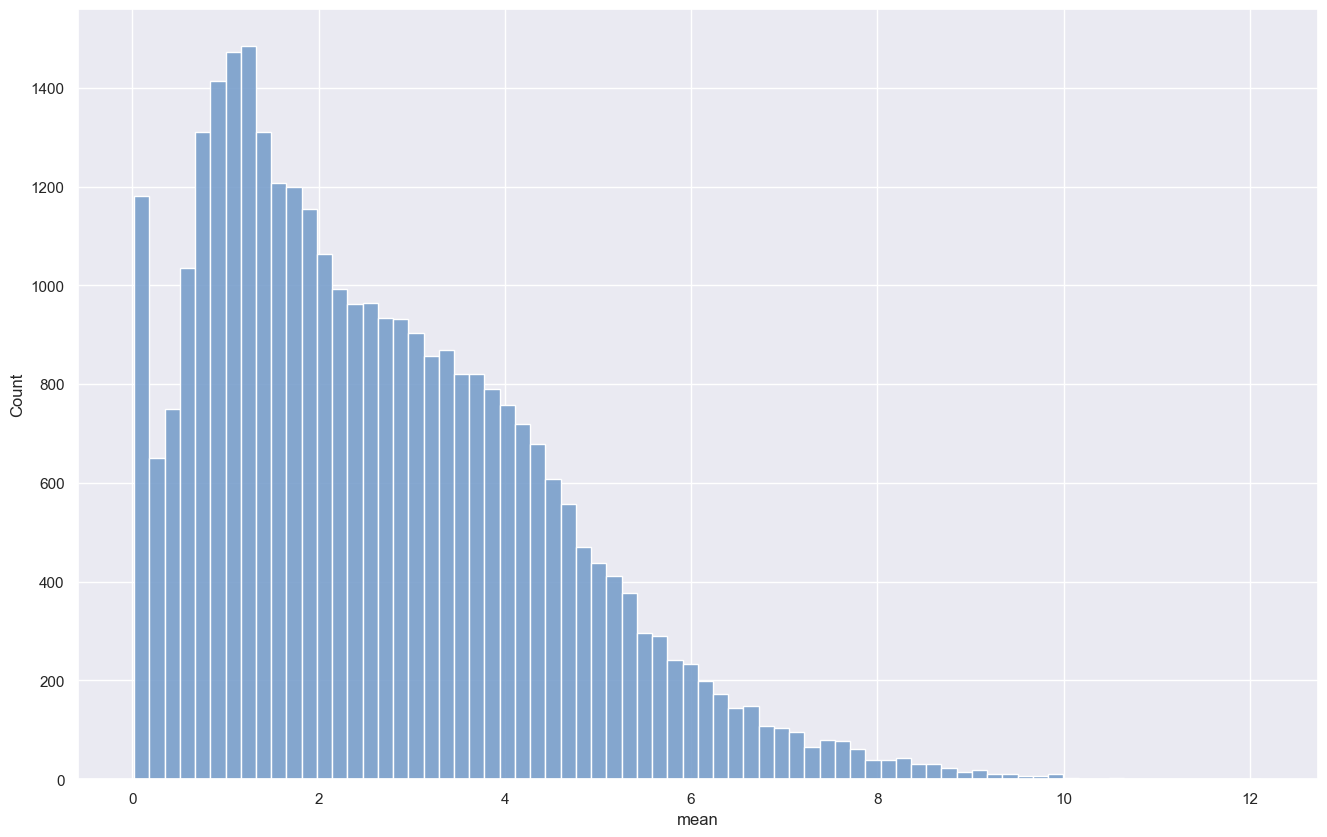

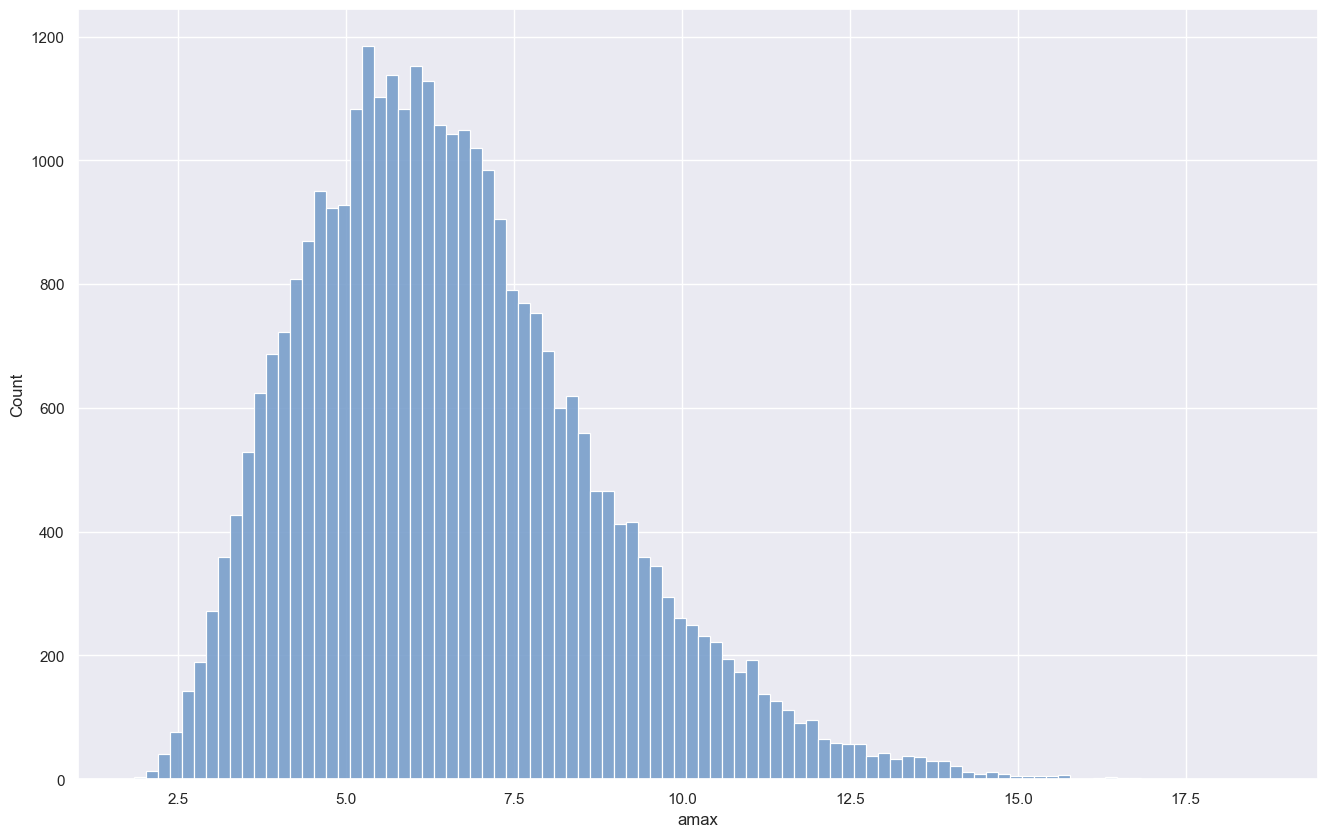

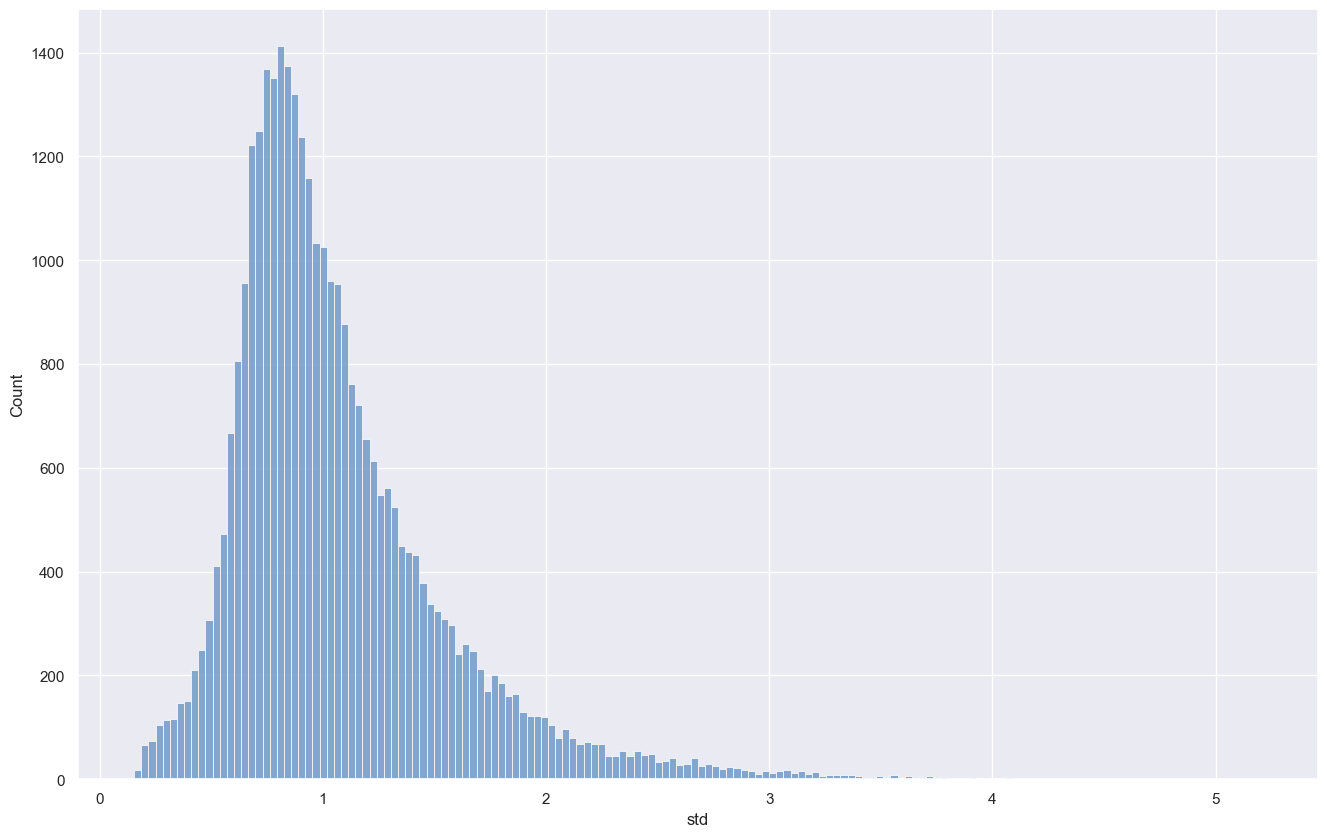

In [11]:
# Display log1p tpm value distribution per gene

data_anndata.tpm_histplot(
	data     = anndata,
	layer    = 'log1p',
	function = numpy.mean,
	filters  = None,
	filename = os.path.join(OUT_PLOT, 'distribution-log1p-mean')
)

data_anndata.tpm_histplot(
	data     = anndata,
	layer    = 'log1p',
	function = numpy.max,
	filters  = None,
	filename = os.path.join(OUT_PLOT, 'distribution-log1p-max')
)

data_anndata.tpm_histplot(
	data     = anndata,
	layer    = 'log1p',
	function = numpy.std,
	filters  = None,
	filename = os.path.join(OUT_PLOT, 'distribution-log1p-std')
)

## 3.2 Genes

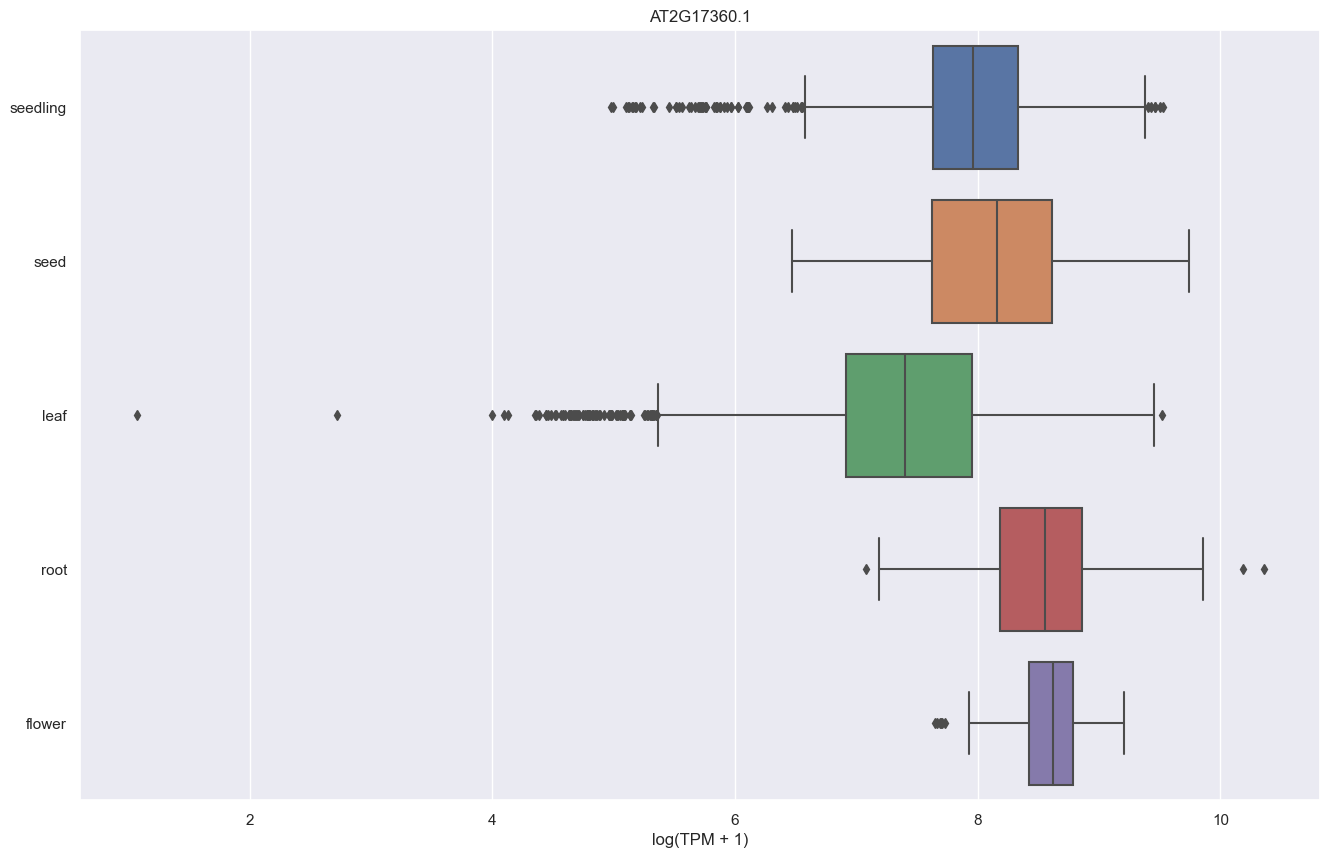

In [12]:
# Display an example of a high-expressive gene <AT2G17360.1>

gene = 'AT2G17360.1'

if gene in anndata.var.index :
	data_anndata.gene_boxplot(
		data     = anndata,
		gene     = gene,
		groupby  = 'Tissue',
		layer    = 'log1p',
		filename = os.path.join(OUT_PLOT, 'tissue-log1p-' + gene)
	)

In [13]:
# Display an example of a tissue-specific expressive gene <AT2G07713.1>

gene = 'AT2G07713.1'

if gene in anndata.var.index :
	data_anndata.gene_boxplot(
		data     = anndata,
		gene     = gene,
		groupby  = 'Tissue',
		layer    = 'log1p',
		filename = os.path.join(OUT_PLOT, 'tissue-log1p-' + gene)
	)

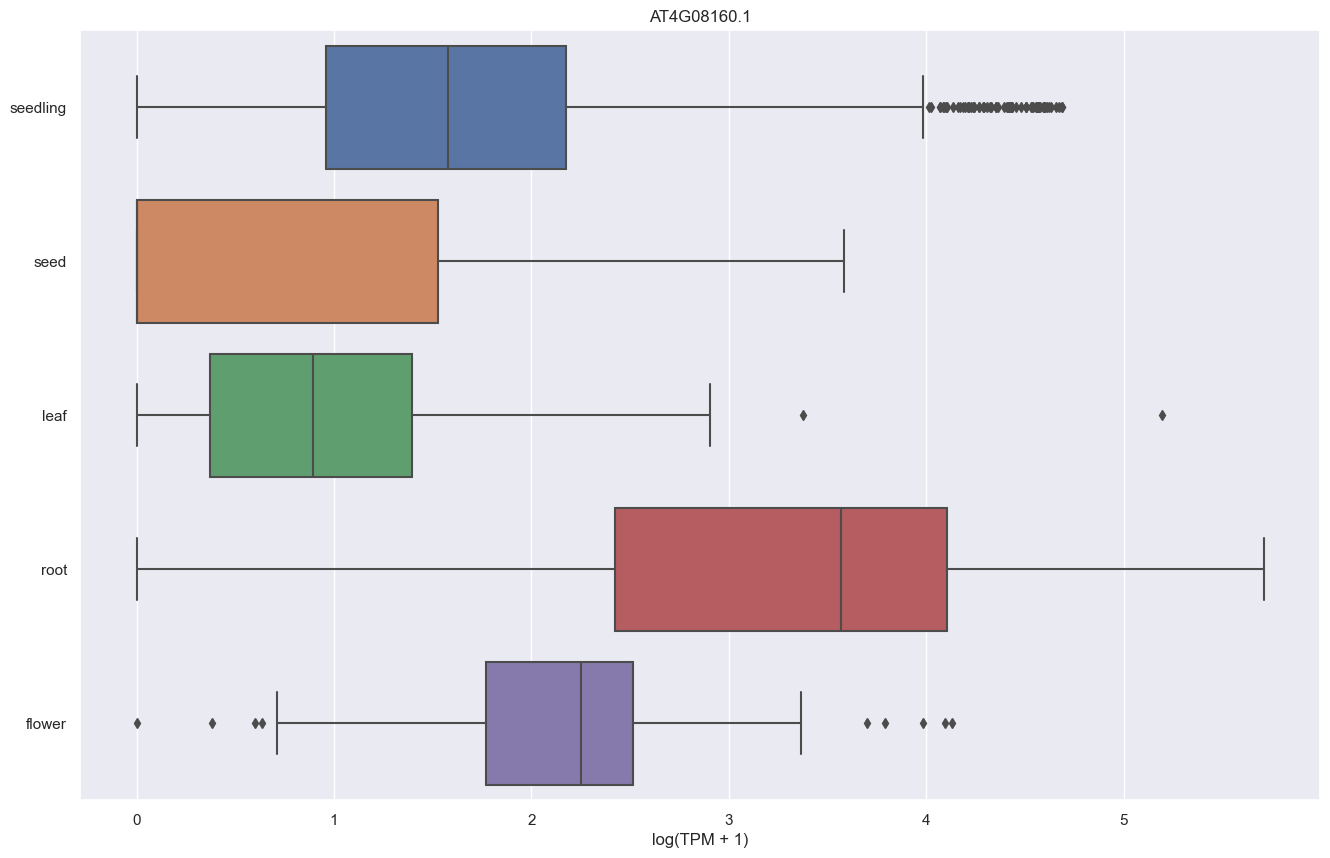

In [14]:
# Display an example of a tissue-prevelant expressive gene <AT4G08160.1>

gene = 'AT4G08160.1'

if gene in anndata.var.index :
	data_anndata.gene_boxplot(
		data     = anndata,
		gene     = gene,
		groupby  = 'Tissue',
		layer    = 'log1p',
		filename = os.path.join(OUT_PLOT, 'tissue-log1p-' + gene)
	)

# 4. BoxCox

In [15]:
# Compute and save the boxcox1p tpm values

anndata = data_anndata.compute_boxcox1p(
	data       = anndata,
	store_into = 'boxcox1p',
	layer      = mapping['boxcox1p'],
	eps        = 1.0
)

boxcox1p lambda : -0.22037471317117235


In [16]:
# Display anndata boxcox1p tpm matrix information

data_anndata.show_matrix(anndata, layer = 'boxcox1p')

   Max value :   4.27402
  Mean value :   1.35933 ± 0.93908
Median value :   1.37860
   Min value :   0.00000

Total elements        : 133,362,747
Total elements =  0.0 :  14,191,035 [ 10.64 %]
Total elements >  0.0 : 119,171,712 [ 89.36 %]
Total elements >  1.0 :  82,232,645 [ 61.66 %]
Total elements >  2.0 :  38,539,733 [ 28.90 %]
Total elements >  3.0 :   4,463,806 [  3.35 %]
Total elements >  4.0 :       4,249 [  0.00 %]

[[  2.165   1.011   1.922   0.000   0.559   0.582   1.738   0.000   2.949   1.350]
 [  2.211   0.000   1.767   1.297   0.776   0.841   1.804   0.686   2.966   0.798]
 [  2.422   0.389   1.891   0.000   0.378   0.489   1.953   0.672   3.004   1.928]
 [  2.331   0.815   1.973   1.241   0.000   0.477   1.858   0.199   3.013   1.709]
 [  2.407   0.997   1.819   0.459   0.585   0.841   1.456   1.673   3.054   0.000]]


## 4.1 Distribution

Function : numpy.mean
Genes below 10th percentile [   0.383747] :  3,271
Genes below 30th percentile [   0.818434] :  9,813
Genes above 70th percentile [   1.831011] :  9,813
Genes above 90th percentile [   2.427413] :  3,271

Function : numpy.amax
Genes below 10th percentile [   2.060902] :  3,271
Genes below 30th percentile [   2.504768] :  9,813
Genes above 70th percentile [   3.087357] :  9,813
Genes above 90th percentile [   3.481769] :  3,271

Function : numpy.std
Genes below 10th percentile [   0.277629] :  3,271
Genes below 30th percentile [   0.364687] :  9,813
Genes above 70th percentile [   0.554256] :  9,813
Genes above 90th percentile [   0.757395] :  3,271



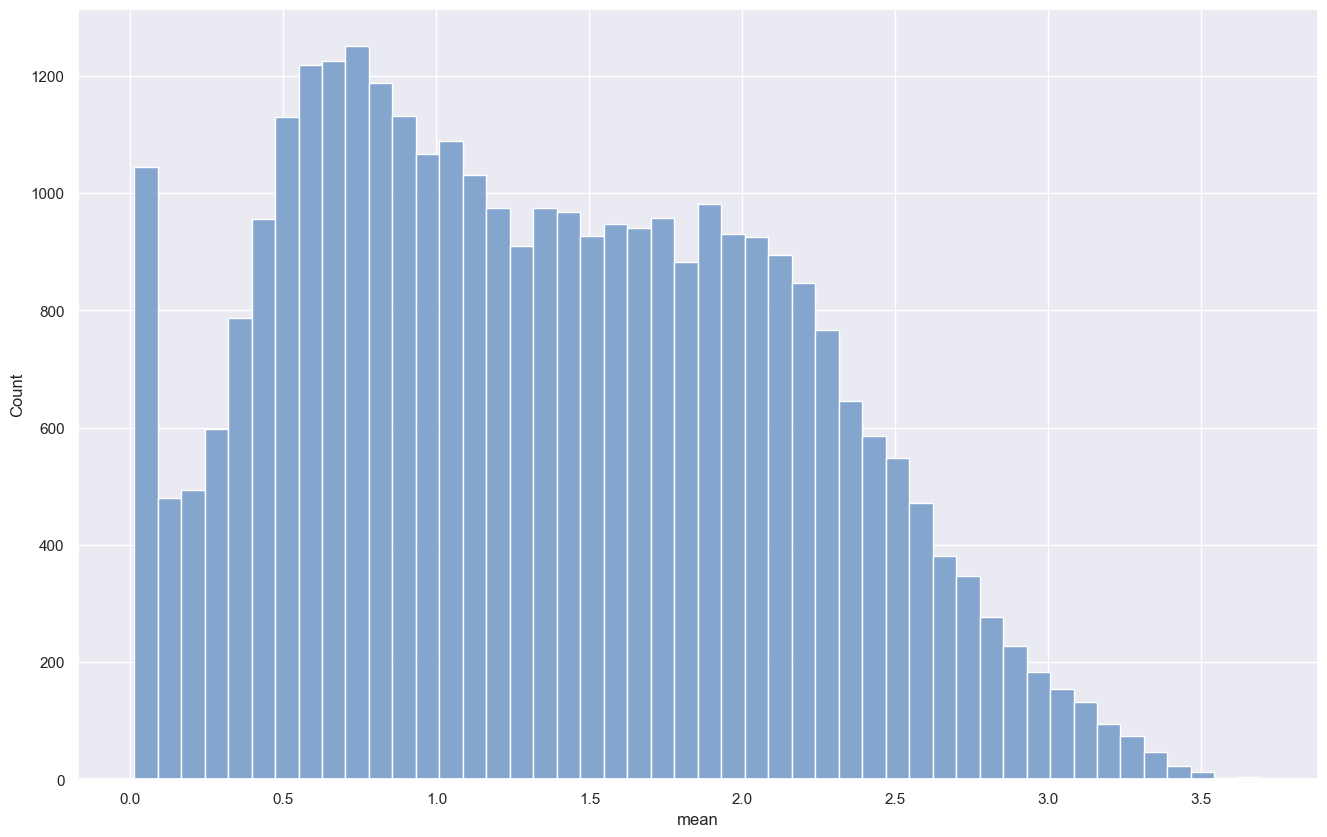

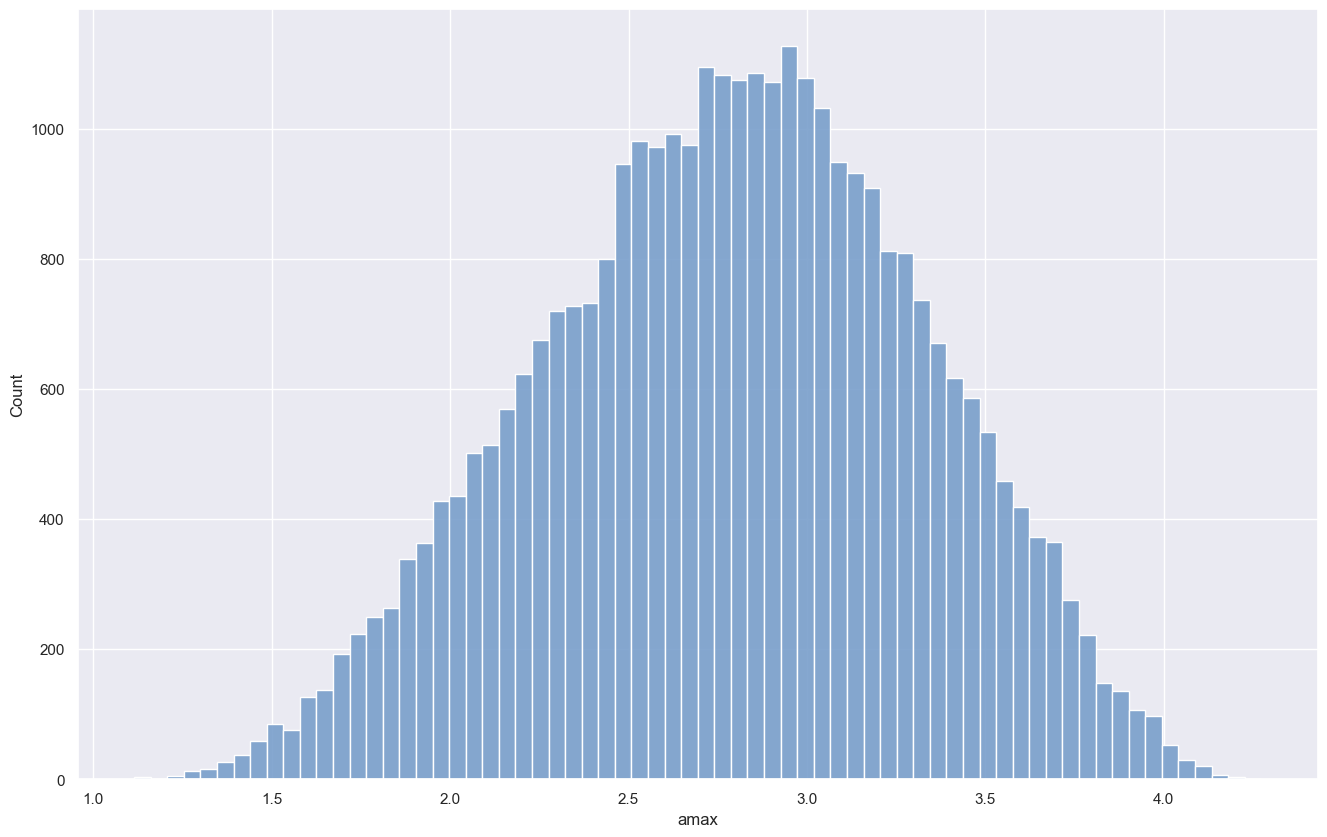

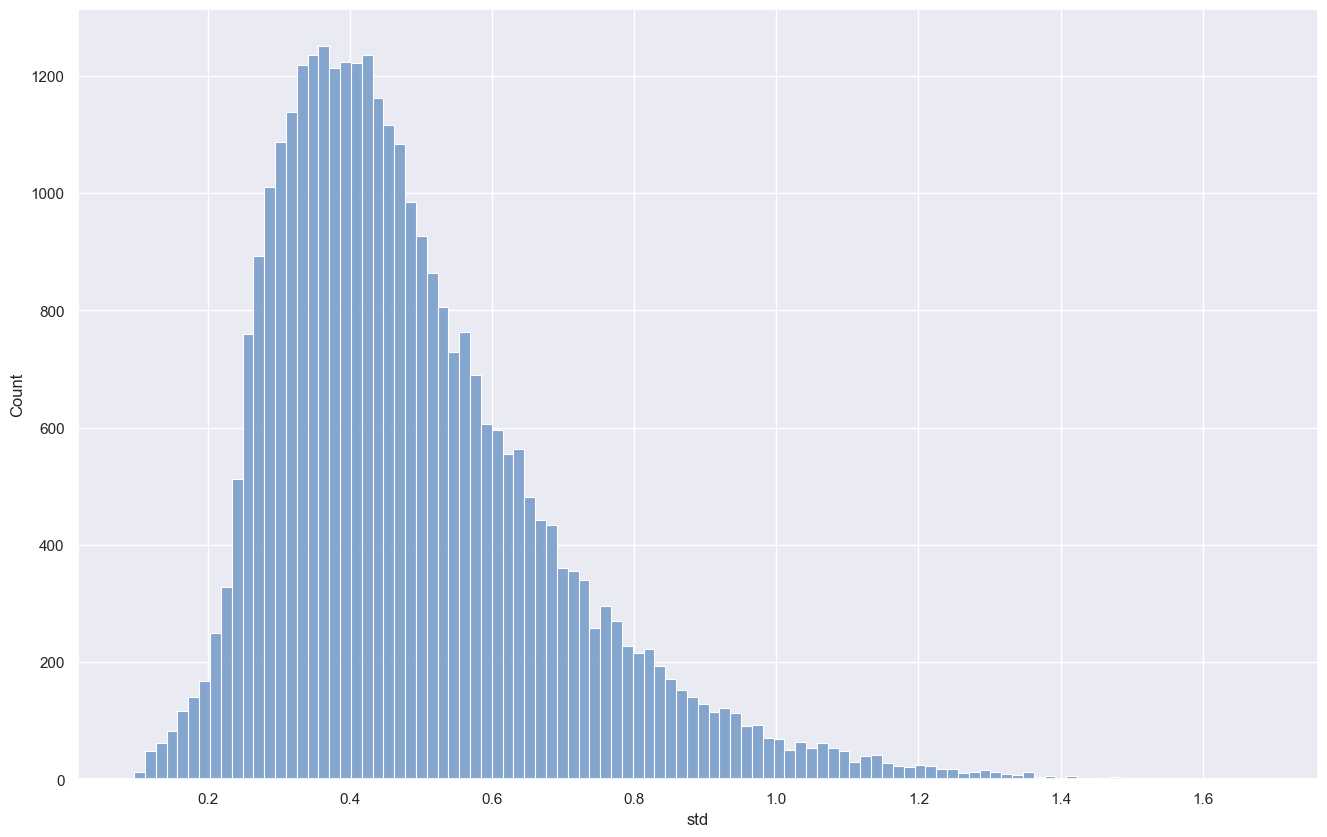

In [17]:
# Display boxcox1p tpm value distribution per gene

data_anndata.tpm_histplot(
	data     = anndata,
	layer    = 'boxcox1p',
	function = numpy.mean,
	filters  = None,
	filename = os.path.join(OUT_PLOT, 'distribution-boxcox1p-mean')
)

data_anndata.tpm_histplot(
	data     = anndata,
	layer    = 'boxcox1p',
	function = numpy.max,
	filters  = None,
	filename = os.path.join(OUT_PLOT, 'distribution-boxcox1p-max')
)

data_anndata.tpm_histplot(
	data     = anndata,
	layer    = 'boxcox1p',
	function = numpy.std,
	filters  = None,
	filename = os.path.join(OUT_PLOT, 'distribution-boxcox1p-std')
)

## 4.2 Genes

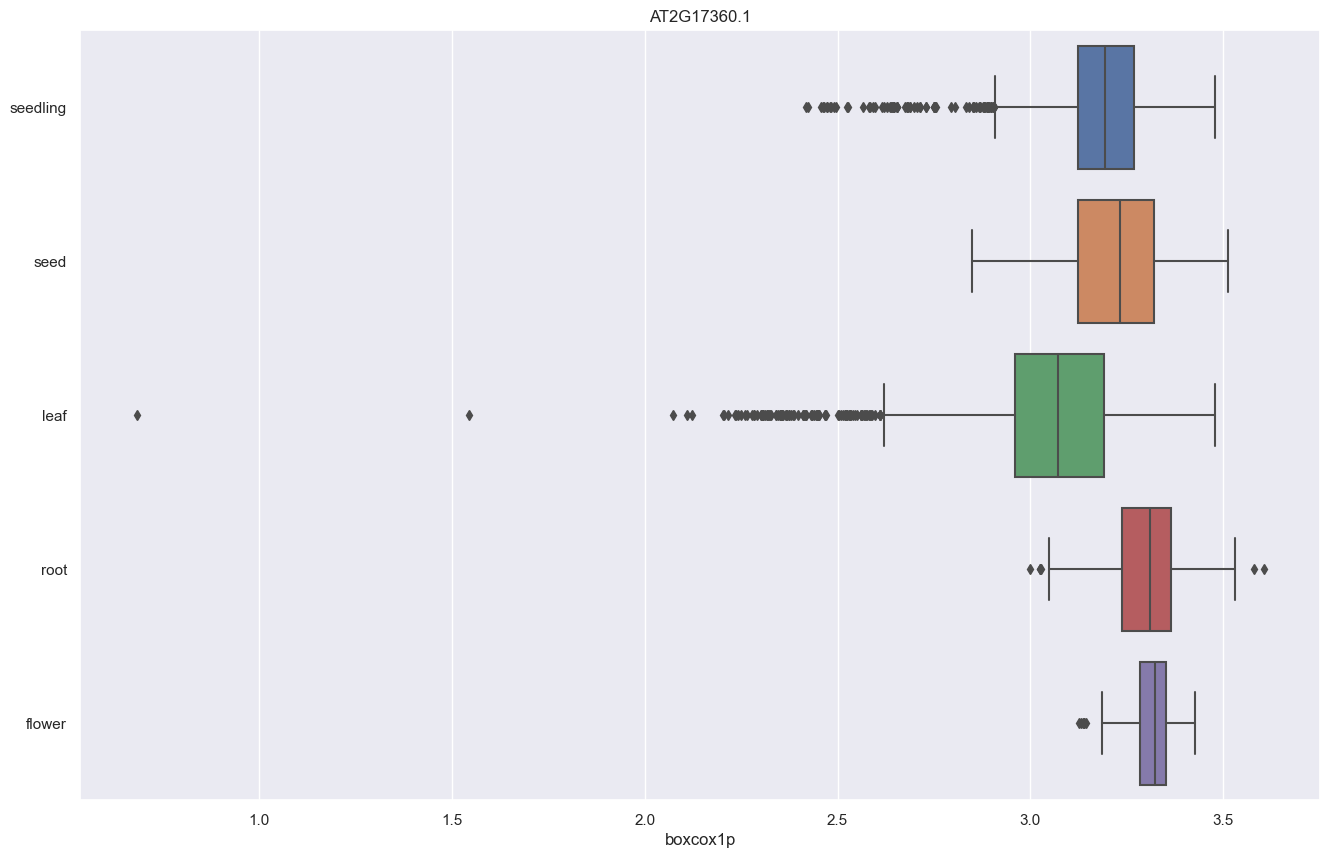

In [18]:
# Display an example of a high-expressive gene <AT2G17360.1>

gene = 'AT2G17360.1'

if gene in anndata.var.index :
	data_anndata.gene_boxplot(
		data     = anndata,
		gene     = gene,
		groupby  = 'Tissue',
		layer    = 'boxcox1p',
		filename = os.path.join(OUT_PLOT, 'tissue-boxcox1p-' + gene)
	)

In [19]:
# Display an example of a tissue-specific expressive gene <AT2G07713.1>

gene = 'AT2G07713.1'

if gene in anndata.var.index :
	data_anndata.gene_boxplot(
		data     = anndata,
		gene     = gene,
		groupby  = 'Tissue',
		layer    = 'boxcox1p',
		filename = os.path.join(OUT_PLOT, 'tissue-boxcox1p-' + gene)
	)

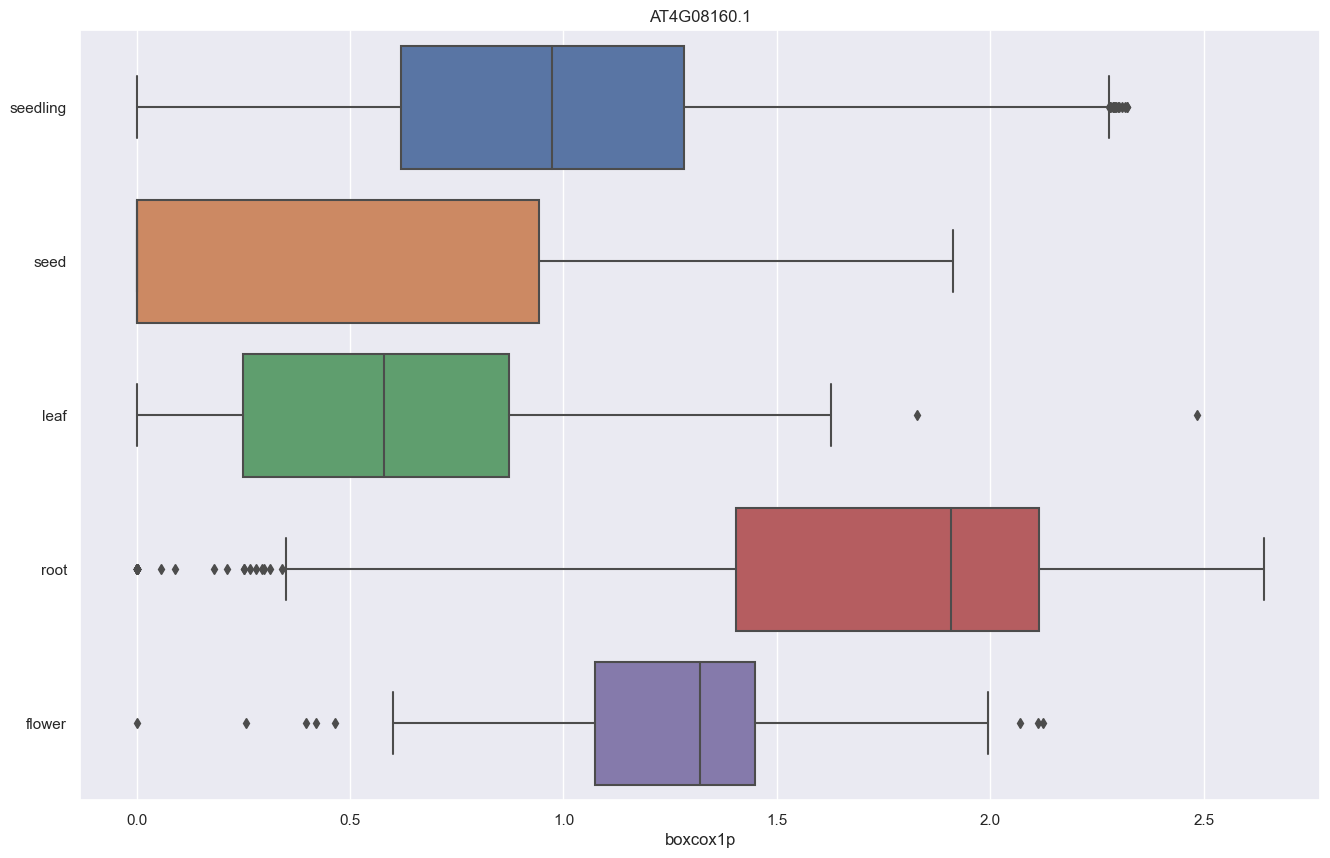

In [20]:
# Display an example of a tissue-prevelant expressive gene <AT4G08160.1>

gene = 'AT4G08160.1'

if gene in anndata.var.index :
	data_anndata.gene_boxplot(
		data     = anndata,
		gene     = gene,
		groupby  = 'Tissue',
		layer    = 'boxcox1p',
		filename = os.path.join(OUT_PLOT, 'tissue-boxcox1p-' + gene)
	)

# 5. Normal

In [21]:
# Compute and save the normalized tpm values

anndata = data_anndata.compute_normalized(
	data       = anndata,
	layer      = mapping['normal'],
	store_into = 'normal'
)

normalize min_value : 0.0
normalize max_value : 4.27402122112829


In [22]:
# Display normalized log1p tpm matrix information

data_anndata.show_matrix(anndata, layer = 'normal')

   Max value :   1.00000
  Mean value :   0.31804 ± 0.21972
Median value :   0.32255
   Min value :   0.00000

Total elements        : 133,362,747
Total elements =  0.0 :  14,191,035 [ 10.64 %]
Total elements >  0.0 : 119,171,712 [ 89.36 %]
Total elements >  0.1 : 103,580,308 [ 77.67 %]
Total elements >  0.3 :  70,740,832 [ 53.04 %]
Total elements >  0.5 :  32,081,346 [ 24.06 %]
Total elements >  0.7 :   4,584,031 [  3.44 %]

[[  0.507   0.237   0.450   0.000   0.131   0.136   0.407   0.000   0.690   0.316]
 [  0.517   0.000   0.414   0.303   0.181   0.197   0.422   0.161   0.694   0.187]
 [  0.567   0.091   0.442   0.000   0.089   0.114   0.457   0.157   0.703   0.451]
 [  0.545   0.191   0.462   0.290   0.000   0.112   0.435   0.047   0.705   0.400]
 [  0.563   0.233   0.426   0.107   0.137   0.197   0.341   0.391   0.715   0.000]]


## 5.1 Distribution

Function : numpy.mean
Genes below 10th percentile [   0.089786] :  3,271
Genes below 30th percentile [   0.191490] :  9,813
Genes above 70th percentile [   0.428405] :  9,813
Genes above 90th percentile [   0.567946] :  3,271

Function : numpy.amax
Genes below 10th percentile [   0.482193] :  3,271
Genes below 30th percentile [   0.586045] :  9,813
Genes above 70th percentile [   0.722354] :  9,813
Genes above 90th percentile [   0.814635] :  3,271

Function : numpy.std
Genes below 10th percentile [   0.064957] :  3,271
Genes below 30th percentile [   0.085326] :  9,813
Genes above 70th percentile [   0.129680] :  9,813
Genes above 90th percentile [   0.177209] :  3,271



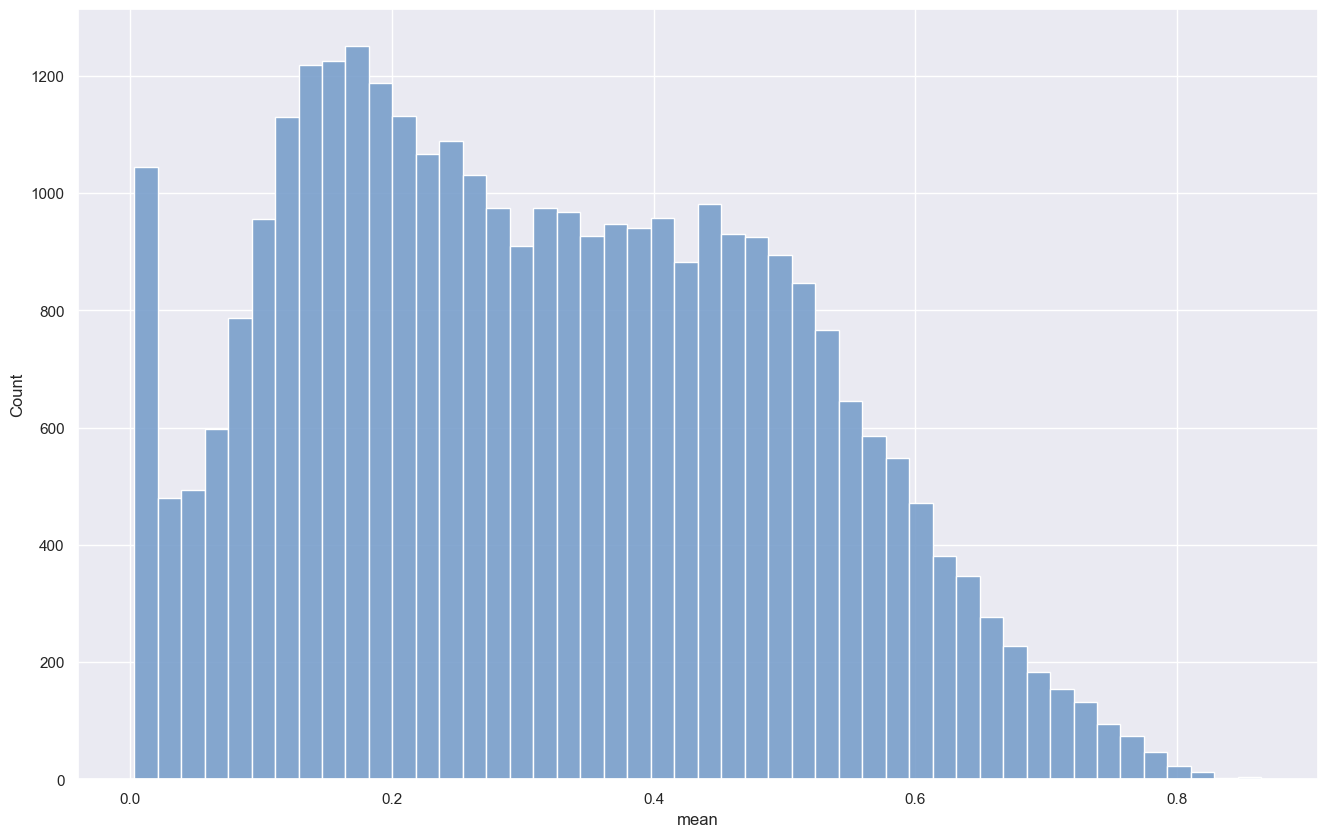

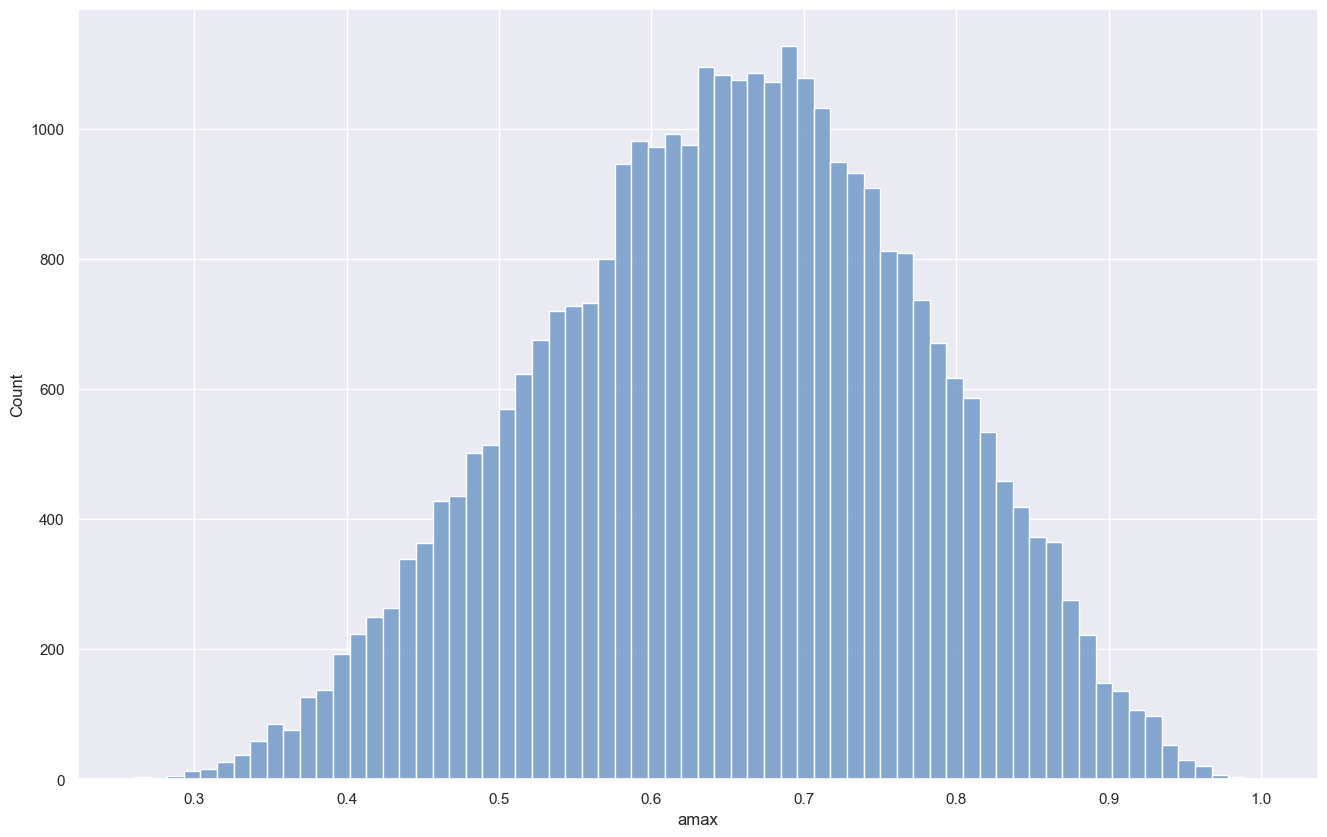

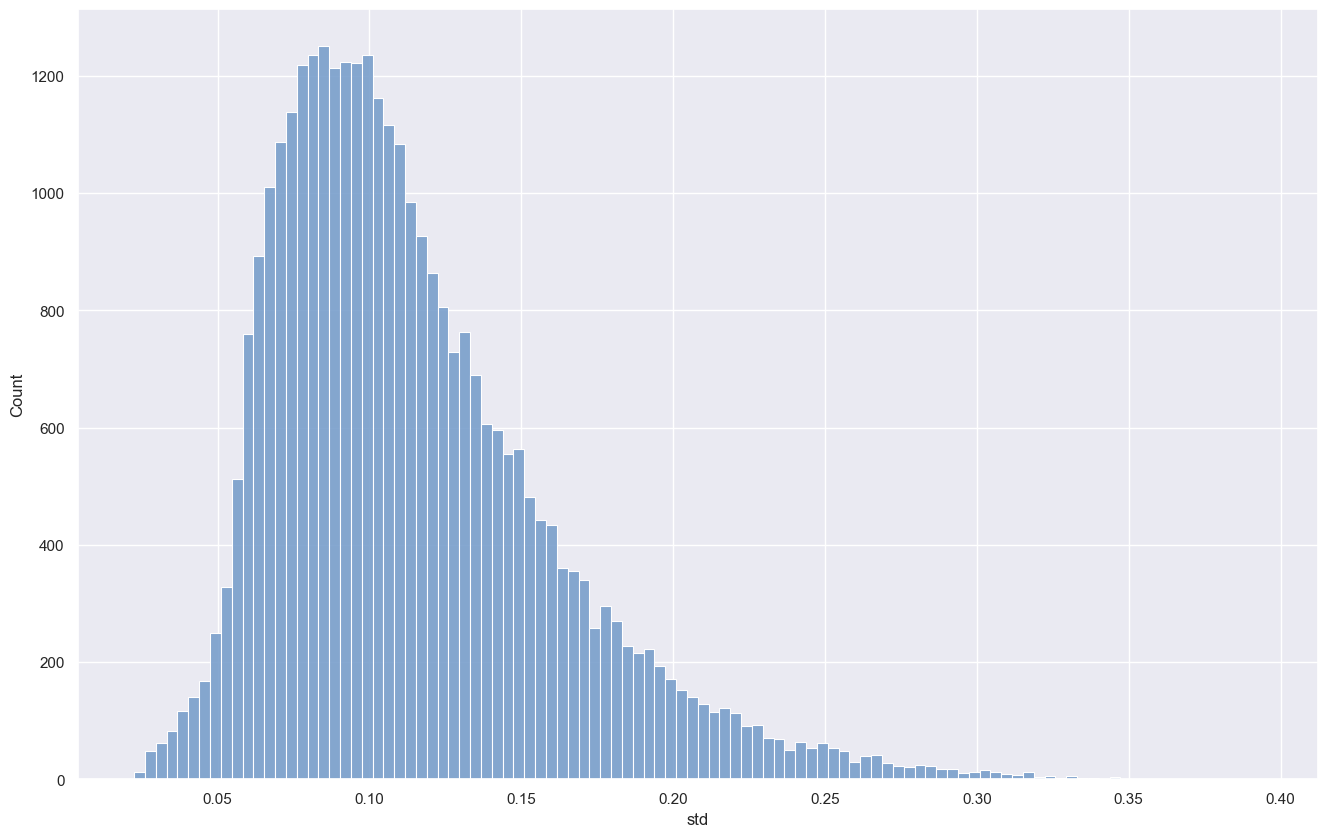

In [23]:
# Display normalized tpm value distribution per gene

data_anndata.tpm_histplot(
	data     = anndata,
	layer    = 'normal',
	function = numpy.mean,
	filters  = None,
	filename = os.path.join(OUT_PLOT, 'distribution-normal-mean')
)

data_anndata.tpm_histplot(
	data     = anndata,
	layer    = 'normal',
	function = numpy.max,
	filters  = None,
	filename = os.path.join(OUT_PLOT, 'distribution-normal-max')
)

data_anndata.tpm_histplot(
	data     = anndata,
	layer    = 'normal',
	function = numpy.std,
	filters  = None,
	filename = os.path.join(OUT_PLOT, 'distribution-normal-std')
)

# 6. Standard

In [24]:
# Compute and save the standardized tpm values

anndata = data_anndata.compute_standardized(
	data       = anndata,
	layer      = mapping['standard'],
	store_into = 'standard',
	axis       = 0
)

In [25]:
# Display anndata standardized tpm matrix information

data_anndata.show_matrix(anndata, layer = 'standard')

   Max value :  20.33351
  Mean value :  -0.00000 ± 1.00000
Median value :   0.02577
   Min value : -19.03544

Total elements        : 133,362,747
Total elements < -5.0 :      54,730 [  0.04 %]
Total elements < -2.0 :   3,507,789 [  2.63 %]
Total elements < -1.0 :  18,536,563 [ 13.90 %]
Total elements < -0.5 :  38,551,060 [ 28.91 %]
Total elements < -0.3 :  47,798,646 [ 35.84 %]
Total elements < -0.0 :  65,381,394 [ 49.03 %]
Total elements =  0.0 :           0 [  0.00 %]
Total elements >  0.0 :  67,981,353 [ 50.97 %]
Total elements >  0.3 :  52,271,882 [ 39.20 %]
Total elements >  0.5 :  41,431,162 [ 31.07 %]
Total elements >  1.0 :  18,136,525 [ 13.60 %]
Total elements >  2.0 :   2,135,162 [  1.60 %]
Total elements >  5.0 :      96,113 [  0.07 %]

[[  0.985  -0.009   1.103  -1.436  -0.388  -0.834   0.498  -2.233   0.493   0.776]
 [  1.069  -1.453   0.872   1.015   0.176  -0.281   0.659  -0.913   0.559   0.111]
 [  1.451  -0.898   1.056  -1.436  -0.857  -1.034   1.028  -0.941   0.703  

# 7. Save

In [26]:
# Save the annotated data with multiple layers

data_writer.write_h5ad(
	data     = anndata,
	filename = os.path.join(OUT_DATA, 'arabidopsis-r36.h5ad')
)